# Day 80: End-to-End ML Pipeline Implementation and Best Practices

Welcome to Day 80 of the 100 Days of Machine Learning Challenge! Today we're going to bring together many of the concepts we've learned so far and explore how to build production-ready, end-to-end machine learning pipelines.

## Introduction

Building machine learning models is only part of the story. In real-world applications, we need robust, reproducible, and maintainable pipelines that can handle data preprocessing, feature engineering, model training, evaluation, and deployment. An end-to-end ML pipeline automates these steps, ensuring consistency and reliability in production environments.

Machine learning pipelines are essential because they:
- **Ensure reproducibility**: The same input data will always produce the same output
- **Prevent data leakage**: Proper separation between training and testing data
- **Simplify deployment**: Encapsulate all transformations in a single object
- **Enable automation**: Streamline the model retraining process
- **Improve maintainability**: Modular code that's easier to update and debug

### Learning Objectives

By the end of this lesson, you will be able to:
- Understand the components of an end-to-end ML pipeline
- Implement data preprocessing pipelines using scikit-learn
- Build feature engineering steps into your pipeline
- Create custom transformers for domain-specific operations
- Apply best practices for pipeline design and validation
- Serialize and deploy ML pipelines for production use

## Theory: Understanding ML Pipelines

### What is a Machine Learning Pipeline?

A machine learning pipeline is a sequence of data processing and modeling steps that are executed in a specific order. Each step in the pipeline transforms the data and passes it to the next step. Mathematically, we can represent a pipeline as a composition of functions:

$$\hat{y} = f_n \circ f_{n-1} \circ \cdots \circ f_2 \circ f_1(X)$$

where:
- $X$ is the input data
- $f_1, f_2, \ldots, f_{n-1}$ are transformation steps (e.g., scaling, encoding)
- $f_n$ is the final estimator (e.g., a classifier or regressor)
- $\hat{y}$ is the predicted output

### Pipeline Components

A typical ML pipeline consists of:

1. **Data Ingestion**: Loading data from various sources (CSV, databases, APIs)
2. **Data Cleaning**: Handling missing values, outliers, and inconsistencies
3. **Feature Engineering**: Creating new features from existing ones
4. **Feature Scaling**: Normalizing or standardizing numeric features
5. **Feature Encoding**: Converting categorical variables to numeric representations
6. **Model Training**: Fitting the machine learning algorithm
7. **Model Evaluation**: Assessing performance on validation data

### Mathematical Foundation of Transformations

#### Standardization (Z-score Normalization)

Standardization transforms features to have zero mean and unit variance:

$$z = \frac{x - \mu}{\sigma}$$

where:
- $x$ is the original feature value
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation
- $z$ is the standardized value

#### Min-Max Scaling

Min-Max scaling transforms features to a specific range, typically [0, 1]:

$$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

#### One-Hot Encoding

For a categorical variable with $k$ unique values, one-hot encoding creates $k$ binary columns:

$$\text{Category}_i \rightarrow [0, 0, \ldots, 1, \ldots, 0]$$

where the $i$-th position is 1 and all others are 0.

### Why Pipelines Prevent Data Leakage

Data leakage occurs when information from the test set influences the training process. Pipelines prevent this by:
- Fitting transformers only on training data
- Applying the same fitted transformations to test data
- Ensuring no test set statistics (mean, std, etc.) contaminate the training process

For example, if we standardize features, we must use:

$$z_{test} = \frac{x_{test} - \mu_{train}}{\sigma_{train}}$$

not

$$z_{test} = \frac{x_{test} - \mu_{test}}{\sigma_{test}}$$

The first approach is correct because we use training set statistics ($\mu_{train}$, $\sigma_{train}$) to transform test data, preventing information leakage.

## Python Implementation

Let's implement a comprehensive ML pipeline using scikit-learn. We'll work with a real dataset and build a pipeline that handles all preprocessing steps.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4
Pandas version: 2.3.3


### Step 1: Data Ingestion and Exploration

We'll use the Adult Census Income dataset, which is a classic dataset for binary classification. The task is to predict whether a person earns more than $50K per year based on demographic features.

In [2]:
# Load the Adult Census Income dataset
# This dataset contains demographic information and income labels
print("Loading Adult Census Income dataset...")

# For demonstration, we'll create a synthetic dataset similar to Adult Census
# In practice, you would load from: data = fetch_openml('adult', version=2, as_frame=True)

np.random.seed(42)
n_samples = 1000

# Create synthetic data
data = pd.DataFrame({
    'age': np.random.randint(18, 80, n_samples),
    'education_num': np.random.randint(1, 16, n_samples),
    'hours_per_week': np.random.randint(1, 100, n_samples),
    'workclass': np.random.choice(['Private', 'Self-emp', 'Government', 'Other'], n_samples),
    'education': np.random.choice(['HS-grad', 'Bachelors', 'Masters', 'Doctorate'], n_samples),
    'marital_status': np.random.choice(['Married', 'Single', 'Divorced'], n_samples),
    'occupation': np.random.choice(['Tech-support', 'Sales', 'Executive', 'Craft-repair'], n_samples),
    'relationship': np.random.choice(['Husband', 'Wife', 'Not-in-family', 'Own-child'], n_samples),
    'race': np.random.choice(['White', 'Black', 'Asian-Pac-Islander', 'Other'], n_samples),
    'sex': np.random.choice(['Male', 'Female'], n_samples),
    'capital_gain': np.random.exponential(1000, n_samples),
    'capital_loss': np.random.exponential(500, n_samples),
})

# Create target variable based on features (with some correlation)
income_prob = (
    0.3 * (data['age'] / 80) +
    0.3 * (data['education_num'] / 16) +
    0.2 * (data['hours_per_week'] / 100) +
    0.2 * (data['capital_gain'] / data['capital_gain'].max())
)
data['income'] = (income_prob + np.random.normal(0, 0.2, n_samples) > 0.5).astype(int)

# Introduce some missing values randomly
for col in ['workclass', 'occupation']:
    mask = np.random.random(n_samples) < 0.05
    data.loc[mask, col] = np.nan

print(f"Dataset shape: {data.shape}")
print(f"\nFirst few rows:")
print(data.head())
print(f"\nData types:")
print(data.dtypes)
print(f"\nMissing values:")
print(data.isnull().sum())
print(f"\nTarget distribution:")
print(data['income'].value_counts())

Loading Adult Census Income dataset...
Dataset shape: (1000, 13)

First few rows:
   age  education_num  hours_per_week   workclass  education marital_status  \
0   56             11               4  Government    HS-grad        Married   
1   69              5              93       Other  Doctorate       Divorced   
2   46             10              86    Self-emp    Masters       Divorced   
3   32             15              25     Private    Masters        Married   
4   60              9              13  Government  Doctorate        Married   

     occupation   relationship                race     sex  capital_gain  \
0     Executive  Not-in-family               White    Male    122.577663   
1     Executive           Wife  Asian-Pac-Islander  Female   2037.772469   
2  Craft-repair        Husband               Black    Male    639.087924   
3  Tech-support  Not-in-family               Other  Female   1247.863284   
4     Executive        Husband  Asian-Pac-Islander    Male    4

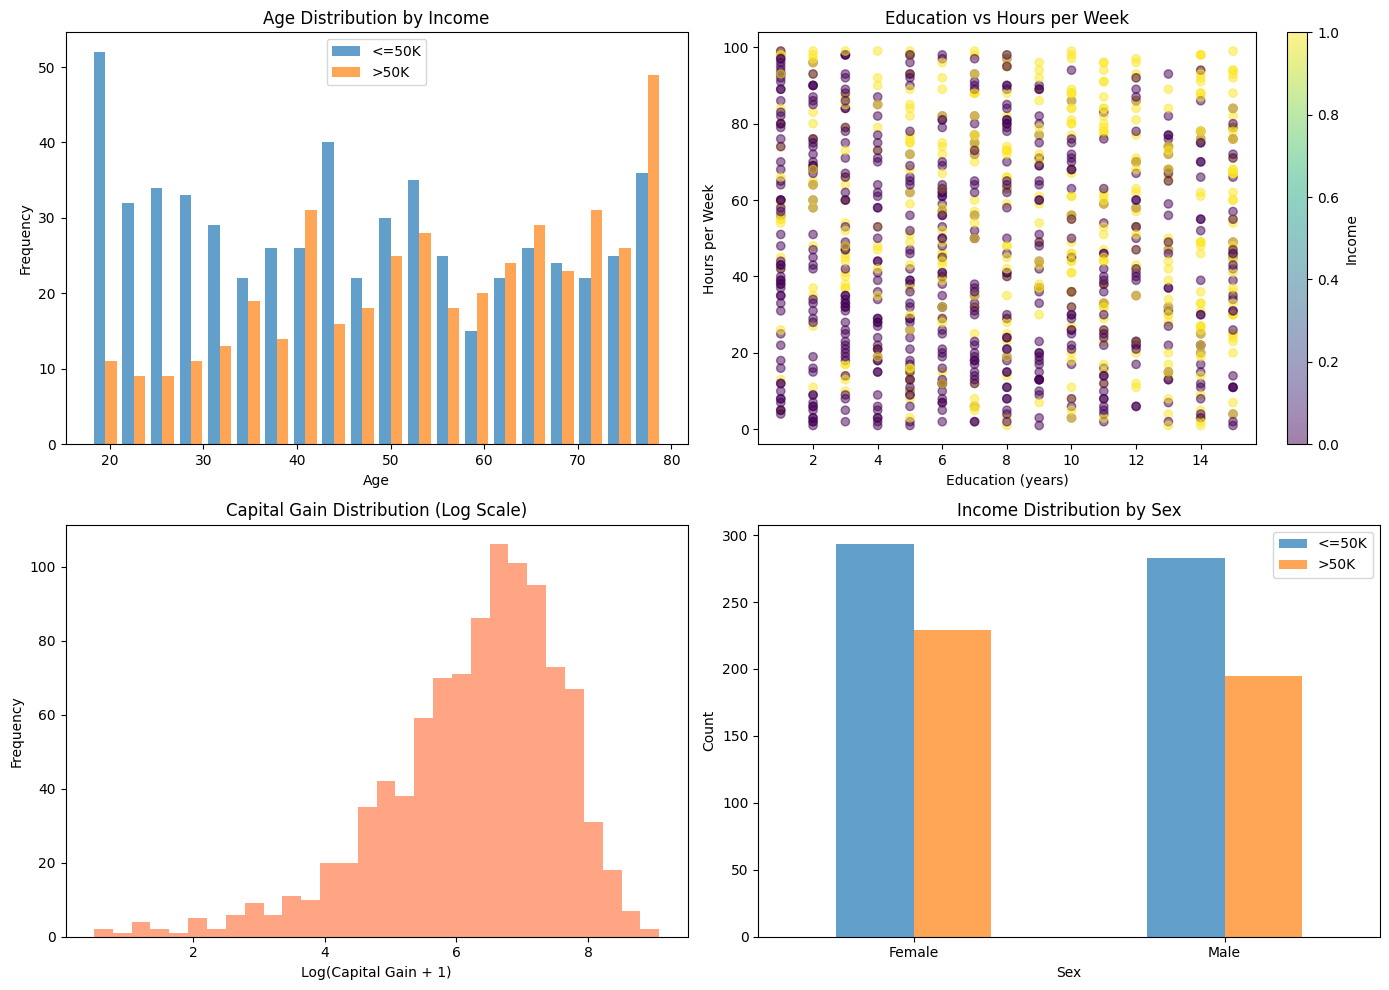

Data exploration complete!


In [3]:
# Visualize the dataset
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution by income
axes[0, 0].hist([data[data['income'] == 0]['age'], data[data['income'] == 1]['age']], 
                label=['<=50K', '>50K'], bins=20, alpha=0.7)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution by Income')
axes[0, 0].legend()

# Education vs Hours per week
scatter = axes[0, 1].scatter(data['education_num'], data['hours_per_week'], 
                             c=data['income'], alpha=0.5, cmap='viridis')
axes[0, 1].set_xlabel('Education (years)')
axes[0, 1].set_ylabel('Hours per Week')
axes[0, 1].set_title('Education vs Hours per Week')
plt.colorbar(scatter, ax=axes[0, 1], label='Income')

# Capital gain distribution
axes[1, 0].hist(np.log1p(data['capital_gain']), bins=30, alpha=0.7, color='coral')
axes[1, 0].set_xlabel('Log(Capital Gain + 1)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Capital Gain Distribution (Log Scale)')

# Income distribution by sex
income_by_sex = data.groupby(['sex', 'income']).size().unstack()
income_by_sex.plot(kind='bar', ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_xlabel('Sex')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Income Distribution by Sex')
axes[1, 1].legend(['<=50K', '>50K'])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("Data exploration complete!")

### Step 2: Designing the Pipeline

Now we'll design a comprehensive pipeline that handles:
1. Numeric features: Imputation and scaling
2. Categorical features: Imputation and one-hot encoding
3. Custom transformations: Log transformation for skewed features
4. Model training: Using a classifier

The key insight here is that **different features require different preprocessing**. Numeric features need scaling, while categorical features need encoding. We'll use `ColumnTransformer` to apply different transformations to different columns.

In [4]:
# Separate features and target
X = data.drop('income', axis=1)
y = data['income']

# Identify numeric and categorical columns
numeric_features = ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 
                       'relationship', 'race', 'sex']

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))

Numeric features: ['age', 'education_num', 'hours_per_week', 'capital_gain', 'capital_loss']
Categorical features: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex']

Training set size: (800, 12)
Testing set size: (200, 12)

Training set target distribution:
income
0    0.57625
1    0.42375
Name: proportion, dtype: float64


### Step 3: Creating Custom Transformers

Sometimes we need domain-specific transformations that aren't available in scikit-learn. We can create custom transformers by inheriting from `BaseEstimator` and `TransformerMixin`.

Here we'll create a transformer that applies a log transformation to skewed features, which can help normalize distributions and improve model performance.

In [5]:
class LogTransformer(BaseEstimator, TransformerMixin):
    """Apply log transformation to specified columns.
    
    This transformer applies log(x + 1) transformation to handle
    skewed distributions and zero values.
    """
    
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # No fitting necessary for log transformation
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if self.columns:
            for col in self.columns:
                if col in X_copy.columns:
                    X_copy[col] = np.log1p(X_copy[col])
        return X_copy


class FeatureCreator(BaseEstimator, TransformerMixin):
    """Create new features from existing ones.
    
    This demonstrates how to add domain knowledge to your pipeline.
    """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Create age groups
        if 'age' in X_copy.columns:
            X_copy['age_group'] = pd.cut(X_copy['age'], 
                                         bins=[0, 25, 45, 65, 100], 
                                         labels=['young', 'middle', 'senior', 'elderly'])
        
        # Create total capital (gain - loss)
        if 'capital_gain' in X_copy.columns and 'capital_loss' in X_copy.columns:
            X_copy['net_capital'] = X_copy['capital_gain'] - X_copy['capital_loss']
        
        return X_copy


print("Custom transformers created successfully!")
print("\nLogTransformer: Applies log(x+1) to skewed features")
print("FeatureCreator: Creates new features from existing ones")

Custom transformers created successfully!

LogTransformer: Applies log(x+1) to skewed features
FeatureCreator: Creates new features from existing ones


### Step 4: Building the Complete Pipeline

Now we'll combine all our preprocessing steps and the model into a single pipeline. This ensures that:
1. All transformations are learned only from training data
2. The same transformations are applied consistently to test data
3. We can easily deploy the entire pipeline as a single unit

In [6]:
# Define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop any columns not specified
)

# Create the complete pipeline with a classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10))
])

print("Pipeline structure:")
print(pipeline)
print("\n" + "="*60)
print("Pipeline steps:")
for i, (name, transformer) in enumerate(pipeline.steps, 1):
    print(f"{i}. {name}: {type(transformer).__name__}")

Pipeline structure:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education_num',
                                                   'hours_per_week',
                                                   'capital_gain',
                                                   'capital_loss']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                           

### Step 5: Training and Evaluating the Pipeline

With our pipeline defined, training is as simple as calling `fit()`. The pipeline will automatically:
1. Fit all transformers on the training data
2. Transform the training data
3. Train the classifier on the transformed data

In [7]:
# Train the pipeline
print("Training the pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete!")

# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['<=50K', '>50K']))

Training the pipeline...


Training complete!



Training Accuracy: 0.9962
Testing Accuracy: 0.6400

Classification Report (Test Set):
              precision    recall  f1-score   support

       <=50K       0.65      0.79      0.72       115
        >50K       0.61      0.44      0.51        85

    accuracy                           0.64       200
   macro avg       0.63      0.61      0.61       200
weighted avg       0.63      0.64      0.63       200



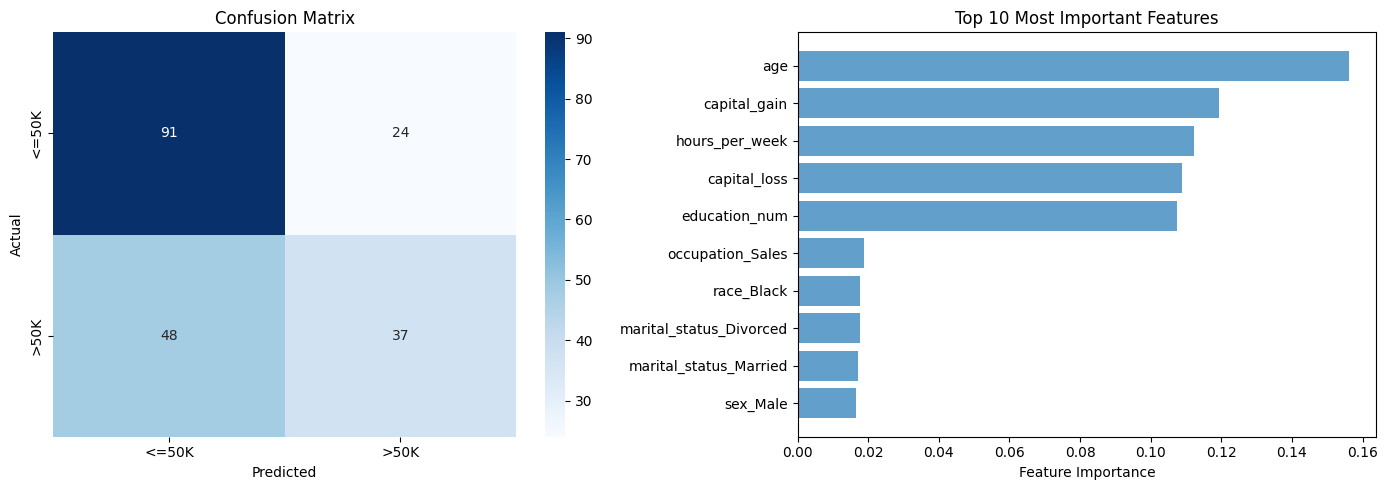

In [8]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# Feature Importance (for Random Forest)
if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = (numeric_features + 
                    list(pipeline.named_steps['preprocessor']
                         .named_transformers_['cat']
                         .named_steps['onehot']
                         .get_feature_names_out(categorical_features)))
    
    importances = pipeline.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features
    
    axes[1].barh(range(len(indices)), importances[indices], alpha=0.7)
    axes[1].set_yticks(range(len(indices)))
    axes[1].set_yticklabels([feature_names[i] for i in indices])
    axes[1].set_xlabel('Feature Importance')
    axes[1].set_title('Top 10 Most Important Features')

plt.tight_layout()
plt.show()

### Step 6: Cross-Validation with Pipelines

One of the major benefits of pipelines is that they work seamlessly with cross-validation. This ensures that each fold's preprocessing is fit only on that fold's training data, preventing data leakage.

The mathematical guarantee is:

For each fold $k$:
$$\text{Train on: } D_{train}^{(k)}, \text{ Validate on: } D_{val}^{(k)}$$
$$\text{Preprocessing parameters } \theta^{(k)} \text{ computed only from } D_{train}^{(k)}$$

Performing 5-fold cross-validation...



Cross-validation scores: [0.70625 0.65625 0.6375  0.6     0.71875]
Mean CV Score: 0.6638 (+/- 0.0878)


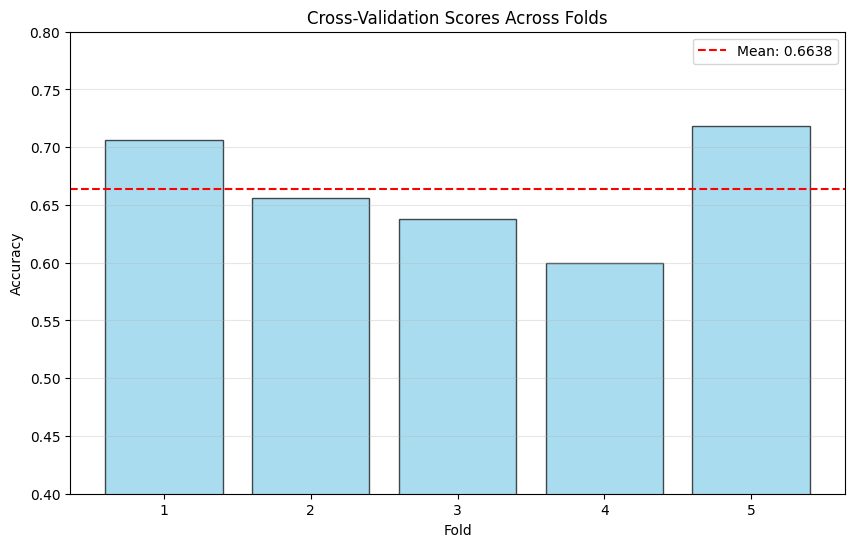

In [9]:
# Perform cross-validation
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, alpha=0.7, color='skyblue', edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores Across Folds')
plt.legend()
plt.ylim(0.4, 0.8)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Step 7: Hyperparameter Tuning with GridSearchCV

Pipelines also integrate seamlessly with hyperparameter tuning. We can tune parameters for both preprocessing steps and the model itself. To reference parameters in the pipeline, we use the syntax: `step_name__parameter_name`.

In [10]:
# Define parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5]
}

print("Performing Grid Search with 3-fold CV...")
print(f"Testing {np.prod([len(v) for v in param_grid.values()])} combinations")

# Perform grid search
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_pipeline = grid_search.best_estimator_
test_score = best_pipeline.score(X_test, y_test)
print(f"Test set score with best parameters: {test_score:.4f}")

Performing Grid Search with 3-fold CV...
Testing 12 combinations
Fitting 3 folds for each of 12 candidates, totalling 36 fits



Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best cross-validation score: 0.6612
Test set score with best parameters: 0.6700


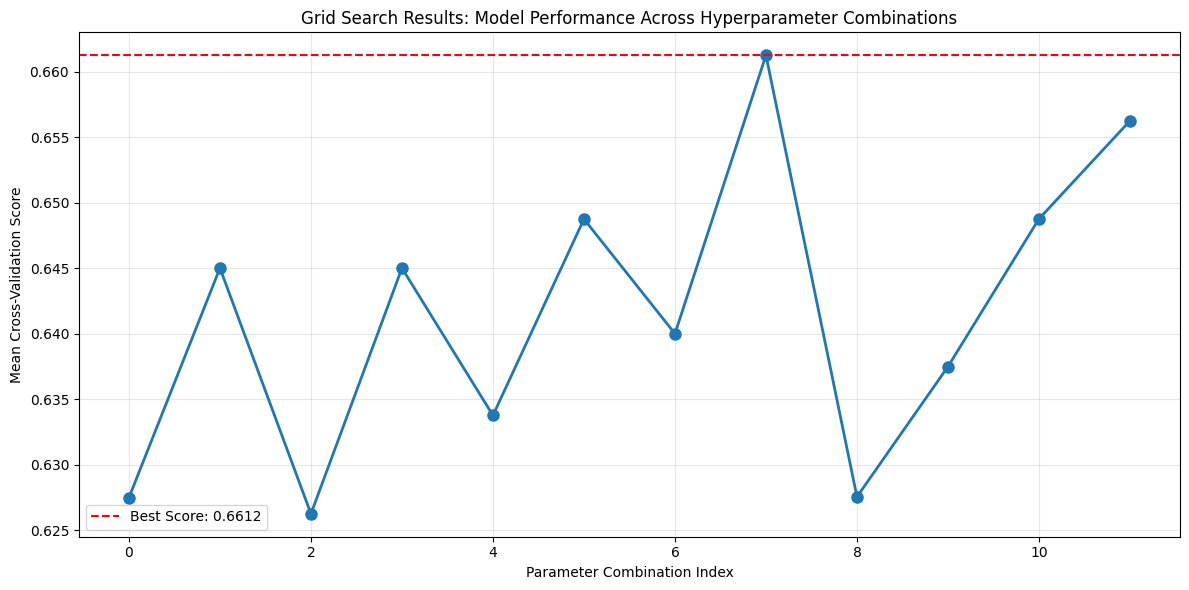


Top 3 parameter combinations:
                                               params  mean_test_score  \
7   {'classifier__max_depth': 10, 'classifier__min...         0.661246   
11  {'classifier__max_depth': 15, 'classifier__min...         0.656243   
10  {'classifier__max_depth': 15, 'classifier__min...         0.648757   

    std_test_score  
7         0.012460  
11        0.015843  
10        0.017244  


In [11]:
# Visualize grid search results
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot mean test scores for different hyperparameter combinations
plt.figure(figsize=(12, 6))
plt.plot(results_df['mean_test_score'], marker='o', linewidth=2, markersize=8)
plt.axhline(y=grid_search.best_score_, color='r', linestyle='--', 
            label=f'Best Score: {grid_search.best_score_:.4f}')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Mean Cross-Validation Score')
plt.title('Grid Search Results: Model Performance Across Hyperparameter Combinations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 3 parameter combinations:")
print(results_df[['params', 'mean_test_score', 'std_test_score']]
      .sort_values('mean_test_score', ascending=False)
      .head(3))

### Step 8: Comparing Multiple Pipelines

A powerful practice is to compare different pipeline configurations. Let's build several pipelines with different classifiers and preprocessing strategies.

In [12]:
# Create multiple pipelines with different classifiers
pipelines = {
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
}

# Evaluate each pipeline
results = {}
print("Comparing multiple pipelines...\n")

for name, pipe in pipelines.items():
    print(f"Training {name}...")
    # Cross-validation
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Fit on full training set and evaluate on test set
    pipe.fit(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_score': test_score
    }
    
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Test Score: {test_score:.4f}\n")

# Create comparison DataFrame
results_df = pd.DataFrame(results).T
print("\nPipeline Comparison Summary:")
print(results_df)

Comparing multiple pipelines...

Training Random Forest...


  CV Score: 0.6625 (+/- 0.0586)
  Test Score: 0.6150

Training Gradient Boosting...


  CV Score: 0.6475 (+/- 0.0465)
  Test Score: 0.6350

Training Logistic Regression...
  CV Score: 0.6600 (+/- 0.0600)
  Test Score: 0.6550


Pipeline Comparison Summary:
                     cv_mean    cv_std  test_score
Random Forest         0.6625  0.029315       0.615
Gradient Boosting     0.6475  0.023251       0.635
Logistic Regression   0.6600  0.030000       0.655


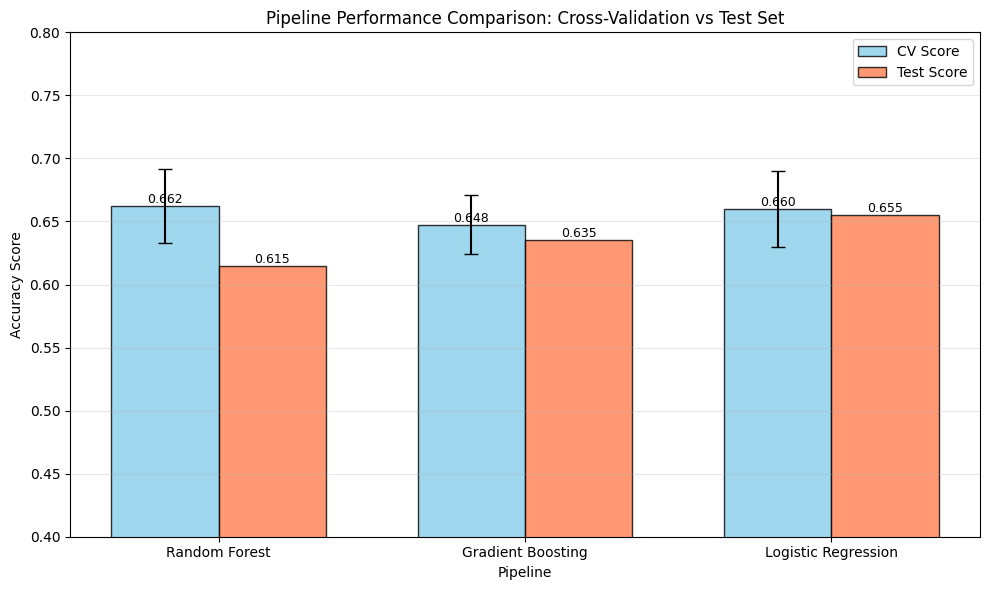

In [13]:
# Visualize pipeline comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['cv_mean'], width, 
               yerr=results_df['cv_std'], label='CV Score', 
               alpha=0.8, capsize=5, color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, results_df['test_score'], width, 
               label='Test Score', alpha=0.8, color='coral', edgecolor='black')

ax.set_xlabel('Pipeline')
ax.set_ylabel('Accuracy Score')
ax.set_title('Pipeline Performance Comparison: Cross-Validation vs Test Set')
ax.set_xticks(x)
ax.set_xticklabels(results.keys())
ax.legend()
ax.set_ylim(0.4, 0.8)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Step 9: Saving and Loading Pipelines

Once we've trained a pipeline, we can save it to disk for later use. This is crucial for deploying models to production. The entire pipeline (preprocessing + model) is saved as a single object.

In [14]:
import joblib

# Save the best pipeline
pipeline_filename = 'income_prediction_pipeline.pkl'
joblib.dump(best_pipeline, pipeline_filename)
print(f"Pipeline saved to {pipeline_filename}")

# Load the pipeline
loaded_pipeline = joblib.load(pipeline_filename)
print(f"Pipeline loaded from {pipeline_filename}")

# Verify it works
sample_predictions = loaded_pipeline.predict(X_test.head())
print(f"\nSample predictions from loaded pipeline: {sample_predictions}")
print(f"Actual labels: {y_test.head().values}")

# Show pipeline size
import os
size_mb = os.path.getsize(pipeline_filename) / (1024 * 1024)
print(f"\nPipeline file size: {size_mb:.2f} MB")

Pipeline saved to income_prediction_pipeline.pkl
Pipeline loaded from income_prediction_pipeline.pkl

Sample predictions from loaded pipeline: [0 0 0 1 1]
Actual labels: [1 0 0 1 1]

Pipeline file size: 1.84 MB


## Hands-On Activity: Build Your Own Pipeline

Now it's your turn! Try building a pipeline for a different dataset. Here's a structured exercise:

### Exercise Instructions

1. **Choose a Dataset**: Use any dataset from scikit-learn or load your own
2. **Explore the Data**: Understand the features, target variable, and data types
3. **Design Your Pipeline**:
   - Identify numeric and categorical features
   - Choose appropriate preprocessing steps
   - Select a classifier or regressor
4. **Implement the Pipeline**: Use `Pipeline` and `ColumnTransformer`
5. **Evaluate Performance**: Use cross-validation and test set evaluation
6. **Compare Models**: Try at least 2 different algorithms
7. **Tune Hyperparameters**: Use `GridSearchCV` or `RandomizedSearchCV`

### Starter Code

In [15]:
# Exercise: Build your own pipeline!

# 1. Create a synthetic regression dataset
from sklearn.datasets import make_regression

# Generate synthetic data for regression
X_housing, y_housing = make_regression(
    n_samples=500,
    n_features=8,
    n_informative=6,
    noise=10,
    random_state=42
)

# Convert to DataFrame for easier handling
feature_names = [f'feature_{i+1}' for i in range(X_housing.shape[1])]
X_housing = pd.DataFrame(X_housing, columns=feature_names)

print("Dataset created!")
print(f"Shape: {X_housing.shape}")
print(f"\nFeatures: {list(X_housing.columns)}")
print(f"\nFirst few rows:")
print(X_housing.head())
print(f"\nTarget statistics:")
print(f"Mean: {y_housing.mean():.2f}, Std: {y_housing.std():.2f}")

# 2. YOUR TURN: Build a regression pipeline
# - Preprocess the features
# - Try different regression algorithms
# - Compare their performance

# Hints:
# - All features are numeric, so you might only need scaling
# - Try: LinearRegression, Ridge, RandomForestRegressor, GradientBoostingRegressor
# - Use mean_squared_error or r2_score for evaluation

# Your code here:
# ...

print("\n" + "="*60)
print("Exercise: Implement your pipeline above!")
print("="*60)

Dataset created!
Shape: (500, 8)

Features: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

First few rows:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.917503  -1.122545   1.537932  -1.148263   0.271495   0.818778   
1  -0.074446   0.257550   0.174578   0.404051  -0.026514   1.886186   
2  -0.968344   0.550052  -0.224633   0.940771  -1.334025  -0.982487   
3   0.640843   1.797687  -0.281100  -0.681984   0.572583  -1.001620   
4   0.828230   1.608781  -1.371743  -0.709789  -0.462940   0.978890   

   feature_7  feature_8  
0   0.811397   1.017661  
1  -0.161286  -1.918771  
2  -0.989628   0.105376  
3  -0.247177  -0.571179  
4  -0.614323   1.090862  

Target statistics:
Mean: 0.90, Std: 133.00

Exercise: Implement your pipeline above!


## Best Practices for ML Pipelines

Based on today's lesson, here are key best practices for building production-ready ML pipelines:

### 1. Data Separation
- **Always** fit preprocessing steps only on training data
- Use the same fitted transformers for test data
- Never use test set statistics in preprocessing

### 2. Pipeline Design
- Use `Pipeline` to chain preprocessing and modeling steps
- Use `ColumnTransformer` for different preprocessing on different columns
- Create custom transformers for domain-specific operations

### 3. Validation Strategy
- Use cross-validation to assess model performance
- Reserve a held-out test set for final evaluation
- Consider using stratified splits for imbalanced data

### 4. Hyperparameter Tuning
- Use `GridSearchCV` or `RandomizedSearchCV` with pipelines
- Tune both preprocessing and model parameters
- Be mindful of computational costs

### 5. Model Deployment
- Save the entire pipeline (not just the model)
- Version your pipelines
- Document preprocessing steps and model parameters
- Test loaded pipelines before deployment

### 6. Code Quality
- Write modular, reusable code
- Add docstrings to custom transformers
- Use meaningful variable names
- Comment complex logic

### 7. Monitoring and Maintenance
- Monitor model performance in production
- Set up alerts for performance degradation
- Plan for regular model retraining
- Keep track of data distribution shifts

## Key Takeaways

Congratulations on completing Day 80! Here's what you should now be able to do:

- **Understand ML Pipelines**: You know what pipelines are, why they're important, and how they prevent data leakage

- **Build Complete Pipelines**: You can create end-to-end pipelines that handle preprocessing, feature engineering, and modeling

- **Handle Different Data Types**: You can apply different preprocessing to numeric and categorical features using `ColumnTransformer`

- **Create Custom Transformers**: You can build domain-specific transformations by extending scikit-learn's base classes

- **Perform Cross-Validation**: You understand how to properly validate models using cross-validation with pipelines

- **Tune Hyperparameters**: You can use `GridSearchCV` to find optimal parameters for your entire pipeline

- **Deploy Pipelines**: You know how to save, load, and deploy complete pipelines for production use

- **Compare Models**: You can systematically compare different pipeline configurations to find the best solution

### Mathematical Concepts Covered

- **Pipeline Composition**: $\hat{y} = f_n \circ f_{n-1} \circ \cdots \circ f_1(X)$
- **Standardization**: $z = \frac{x - \mu}{\sigma}$
- **Min-Max Scaling**: $x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$
- **Data Leakage Prevention**: Using only training statistics for test data transformation

### What's Next?

In the coming lessons, we'll explore:
- Advanced pipeline techniques (feature selection, dimensionality reduction)
- MLOps practices (CI/CD for ML, model monitoring)
- Deep learning pipelines with TensorFlow/PyTorch
- Transformer models and attention mechanisms

## Further Resources

To deepen your understanding of ML pipelines and best practices, check out these resources:

### Official Documentation
- **scikit-learn Pipelines**: https://scikit-learn.org/stable/modules/compose.html
- **ColumnTransformer Guide**: https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
- **Custom Transformers**: https://scikit-learn.org/stable/developers/develop.html

### Tutorials and Articles
- **"Scikit-learn Pipeline Examples"**: Comprehensive examples of pipeline usage
  - https://www.kaggle.com/jankoch/scikit-learn-pipelines
- **"Avoiding Data Leakage"**: Understanding and preventing data leakage
  - https://machinelearningmastery.com/data-leakage-machine-learning/
- **"Building ML Pipelines"**: O'Reilly book on production ML systems
  - https://www.oreilly.com/library/view/building-machine-learning/9781492053187/

### Advanced Topics
- **Feature Engineering**: https://feature-engine.readthedocs.io/
- **MLOps Practices**: https://ml-ops.org/
- **Model Deployment**: https://www.tensorflow.org/tfx/guide/serving

### Practice Datasets
- **UCI Machine Learning Repository**: https://archive.ics.uci.edu/ml/index.php
- **Kaggle Datasets**: https://www.kaggle.com/datasets
- **OpenML**: https://www.openml.org/

### Community and Support
- **scikit-learn Discussions**: https://github.com/scikit-learn/scikit-learn/discussions
- **Stack Overflow**: Tag your questions with `scikit-learn` and `pipeline`
- **Reddit r/MachineLearning**: https://www.reddit.com/r/MachineLearning/

---

**Congratulations on completing Day 80!** You now have the skills to build production-ready ML pipelines. Keep practicing and experimenting with different datasets and pipeline configurations. See you on Day 81!